In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import subprocess
import seaborn as sns
from sklearn.metrics import precision_recall_curve
from prg import prg

In [2]:
def get_target(col):
    return col.split('.')[1].split(':')[0]

def load_target(path, target):
    try:
        return pickle.load(open('{}/{}.pkl'.format(DSC_PATH, path), 'rb'))[target]
    except Exception:
        return []

def load_query_targets(spec):
    """
    load query targets from DSC database
    """
    output_columns = spec.columns[['output' in c for c in spec.columns]]
    spec = deepcopy(spec)
    target2oc = {}
    for oc in output_columns:
        target = get_target(oc)
        if target in target2oc:
            target2oc[target].append(oc)
        else:
            target2oc[target] = [oc]

    for target in target2oc:
        fp = pd.concat([spec.loc[:, target2oc[target][i]].dropna() for i in range(len(target2oc[target]))])
        spec.loc[:, '{}_path'.format(target)] = fp

    targets = list(target2oc.keys())

    for target in targets:
        spec.loc[:, target] = spec.loc[:, '{}_path'.format(target)].apply(
            lambda x: load_target(x, target))
        spec = spec.drop(labels='{}_path'.format(target), axis=1)
    return spec

### Query DSC

In [3]:
DSC_PATH = '../output/cafeh-simulations'

targets = [
    'score_finemapping_caviar.study_pip',
    'fit_cafeh.study_pip fit_susie.study_pip',
    'simulations.true_effects simulations.pve',
    'simulations.n_study',
    'simulations.n_causal_per_study'
]

query_file = 'study_pip_new.xlsx'

cmd_args = [
    'dsc-query', DSC_PATH,
    '-t', ' '.join(targets),
    '-o', query_file
]

subprocess.run('rm {}'.format(query_file), shell=True)
subprocess.run(' '.join(cmd_args), shell=True)

CompletedProcess(args='dsc-query ../output/cafeh-simulations -t score_finemapping_caviar.study_pip fit_cafeh.study_pip fit_susie.study_pip simulations.true_effects simulations.pve simulations.n_study simulations.n_causal_per_study -o study_pip_new.xlsx', returncode=0)

In [4]:
ls -lh

total 3416
-rw-r--r--  1 karltayeb  staff    28K Aug 14 10:52 cset_query.xlsx
-rw-r--r--  1 karltayeb  staff   1.5M Aug 14 10:53 pip_plots.ipynb
-rw-r--r--  1 karltayeb  staff   4.6K Aug 14 10:52 set_evaluation.ipynb
-rw-r--r--  1 karltayeb  staff    66K Aug 14 10:52 study_pip.xlsx
-rw-r--r--  1 karltayeb  staff   6.6K Aug 11 11:41 study_pip3.xlsx
-rw-r--r--  1 karltayeb  staff    66K Aug 14 10:54 study_pip_new.xlsx
-rw-r--r--  1 karltayeb  staff   6.5K Aug 11 10:45 sudy_pip.xlsx
-rw-r--r--  1 karltayeb  staff    16K Aug 13 12:50 sudy_pip2.ipynb
-rw-r--r--  1 karltayeb  staff   8.3K Aug 11 10:45 sudy_pip2.xlsx


In [14]:
xls = pd.ExcelFile('../queries/study_pip_new.xlsx')
info = [xls.parse(x) for x in xls.sheet_names]
spec = pd.read_excel(xls, 'Sheet1')
query = load_query_targets(spec)

In [6]:
# put model names into one column for easier filtering

model_columns = ['fit_cafeh', 'fit_susie', 'score_finemapping_caviar.study_pip:output']
query.loc[:, 'model'] = pd.concat(
    [query.loc[:, mc].dropna().apply(lambda x: '_'.join(x.split('_')[1:])) for mc in model_columns])
query.loc[:, 'model'] = query.model.apply(lambda x: 'CAVIAR' if ('caviar' in x) else x)

### Make PR curves for pips

We can compare finemapping performance of SuSiE, CAVIAR, and CAFEH with (study, variant) PIPs
for SuSie and CAVIAR these are just the PIPs for each study concatenated
for CAFEH we can compute a study level pip: the posterior inclusion probability for a particular study

In [8]:
def make_pr_curve(df, label):
    labels = np.concatenate([x.flatten() != 0 for x in df.true_effects.values])
    pred = np.concatenate([x.flatten() for x in df.study_pip.values])

    p, r, t = precision_recall_curve(labels, pred)
    plt.plot(r, p, label=label)

In [9]:
def make_prg_curve(df, label):
    labels = np.concatenate([x.flatten() != 0 for x in df.true_effects.values])
    pred = np.concatenate([x.flatten() for x in df.study_pip.values])
    prg_curve = prg.create_prg_curve(labels, pred)
    p, r = prg_curve['precision_gain'], prg_curve['recall_gain']
    plt.plot(p, r, label=label)

In [10]:
df = query[query.model == 'cafeh_genotype']
def _plot_pr(X, Y, **kwargs):
    labels = np.concatenate([x.flatten() != 0 for x in X])
    pred = np.concatenate([y.flatten() for y in Y])

    p, r, _ = precision_recall_curve(labels, pred)
    plt.plot(r, p, **kwargs)
    
def _plot_prg(X, Y, **kwargs):
    labels = np.concatenate([x.flatten() != 0 for x in X])
    pred = np.concatenate([y.flatten() for y in Y])
    prg_curve = prg.create_prg_curve(labels, pred)
    p, r = prg_curve['precision_gain'], prg_curve['recall_gain']
    plt.plot(r, p, **kwargs)    

### Precision recall curves

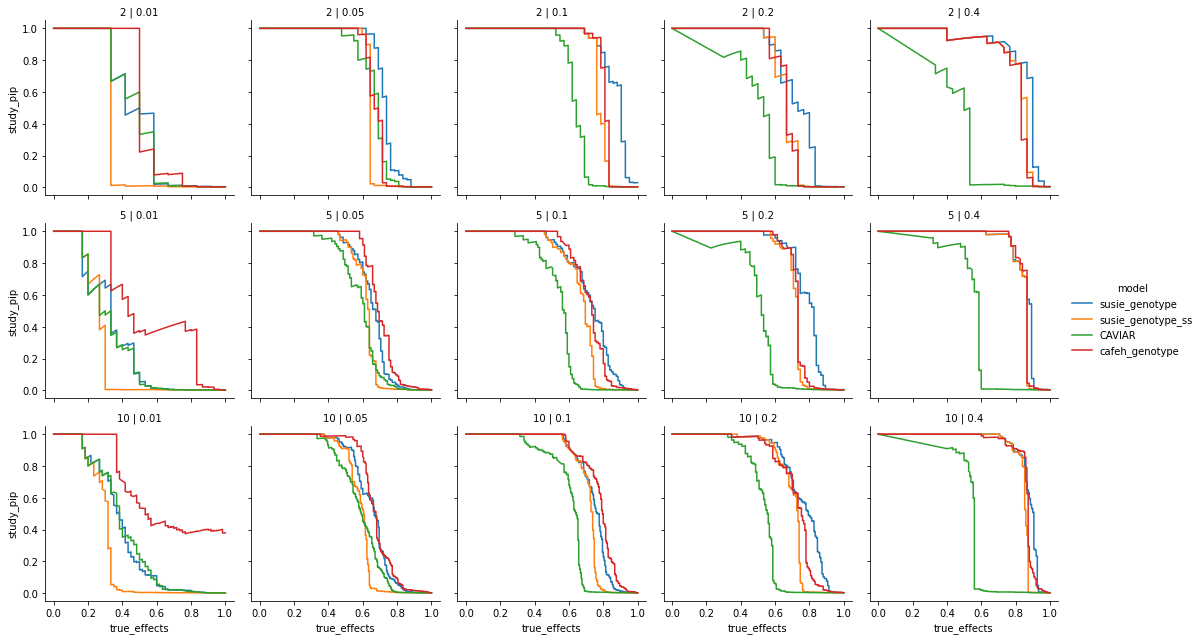

In [13]:
models = ['susie_genotype', 'susie_genotype_ss', 'cafeh_genotype', 'CAVIAR']
df = query[query.model.isin(models)]
g = sns.FacetGrid(df, hue='model', col='simulations.pve', row='simulations.n_study')
g.map(_plot_pr, 'true_effects', 'study_pip')
g.add_legend()
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

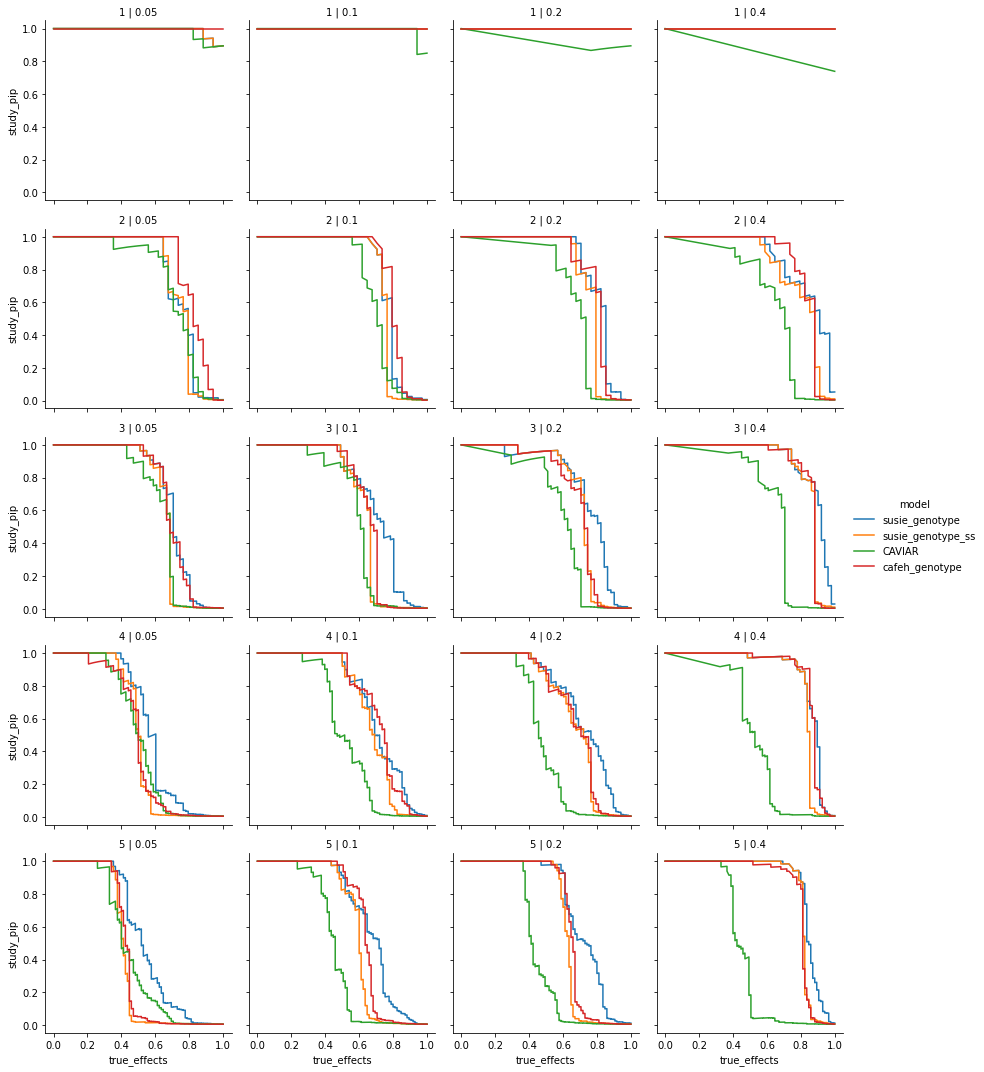

In [12]:
models = ['susie_genotype', 'susie_genotype_ss', 'cafeh_genotype', 'CAVIAR']
df = query[query.model.isin(models) & (query.simulations == 'tissue_specific_sim')]
g = sns.FacetGrid(df, hue='model', col='simulations.pve', row='simulations.n_causal_per_study')
g.map(_plot_pr, 'true_effects', 'study_pip')
g.add_legend();
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

### Precision Recall Gain Curves

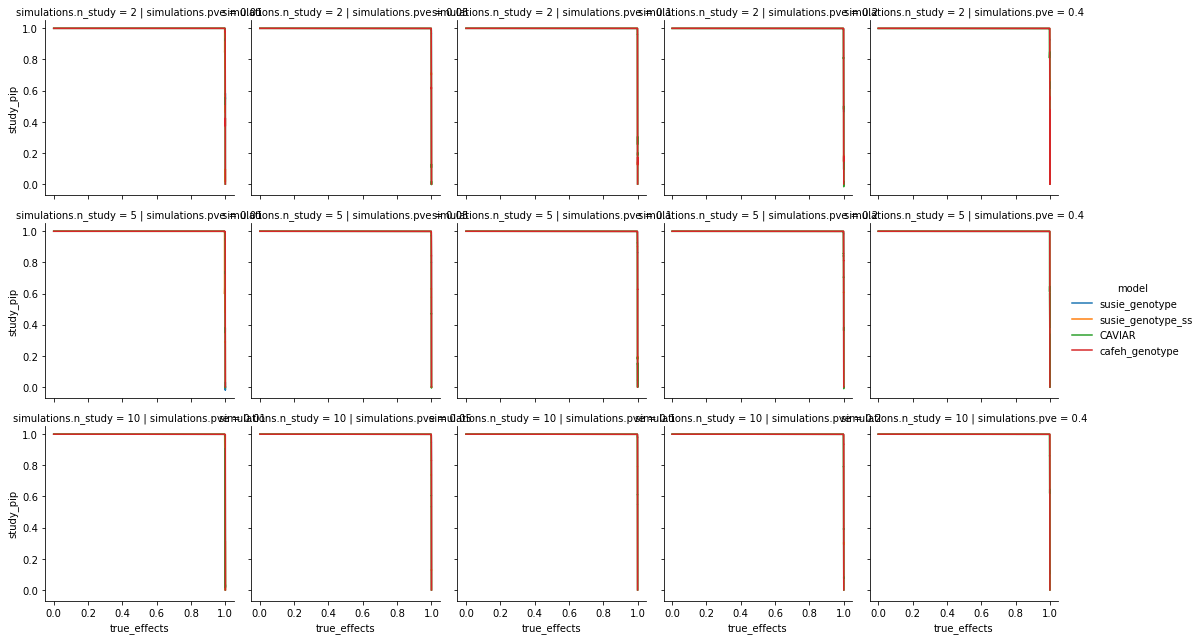

In [58]:
models = ['susie_genotype', 'susie_genotype_ss', 'cafeh_genotype', 'CAVIAR']
df = query[query.model.isin(models)]
g = sns.FacetGrid(df, hue='model', col='simulations.pve', row='simulations.n_study')
g.map(_plot_prg, 'true_effects', 'study_pip')
g.add_legend();

### PIP plots

In [17]:
df = query[query.model.isin(models) & (query.simulations == 'tissue_specific_sim')]
#g = sns.FacetGrid(df, hue='model', col='simulations.pve', row='simulations.n_causal_per_study')

In [20]:
df.columns

Index(['DSC', 'score_finemapping_caviar.study_pip:output', 'fit_cafeh',
       'fit_cafeh.study_pip:output', 'fit_susie', 'fit_susie.study_pip:output',
       'simulations', 'simulations.true_effects:output', 'simulations.pve',
       'simulations.n_study', 'simulations.n_causal_per_study', 'study_pip',
       'true_effects', 'model'],
      dtype='object')

In [24]:
df = query[query.model.isin(models) & (query.simulations == 'tissue_specific_sim')]
pivot = pd.pivot(df, 'simulations.true_effects:output', 'model', 'study_pip')

In [25]:
def _flat_scatter(X, Y, **kwargs):
    x = np.concatenate([x.flatten() != 0 for x in X])
    y = np.concatenate([y.flatten() for y in Y])
    plt.scatter(x, y)

In [30]:
for i, row in pivot.iterrows():
    break

In [45]:
query.columns

Index(['DSC', 'score_finemapping_caviar.study_pip:output', 'fit_cafeh',
       'fit_cafeh.study_pip:output', 'fit_susie', 'fit_susie.study_pip:output',
       'simulations', 'simulations.true_effects:output', 'simulations.pve',
       'simulations.n_study', 'simulations.n_causal_per_study', 'study_pip',
       'true_effects', 'model'],
      dtype='object')

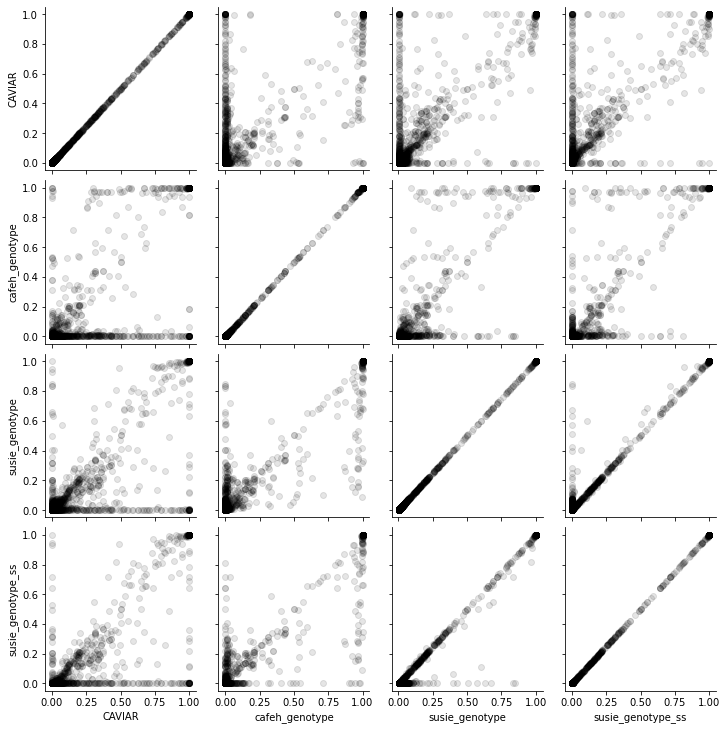

In [46]:
df = query[query.model.isin(models) & (query.loc[:, 'simulations.n_causal_per_study'] <=2)]
pivot = pd.pivot(df, 'simulations.true_effects:output', 'model', 'study_pip')
pivot = pd.concat(
    [pd.DataFrame(np.stack([x.flatten() for x in row.values]).T, columns=row.index)
     for _, row in pivot.iterrows()])

g = sns.PairGrid(pivot)
g = g.map(plt.scatter, color='k', alpha=0.1)

In [40]:
df = query[query.model.isin(models) & (query.simulations == 'tissue_specific_sim')]
pivot = pd.pivot(df, 'simulations.true_effects:output', 'model', 'study_pip')
pivot = pd.concat(
    [pd.DataFrame(np.stack([x.flatten() for x in row.values]).T, columns=row.index)
     for _, row in pivot.iterrows()])

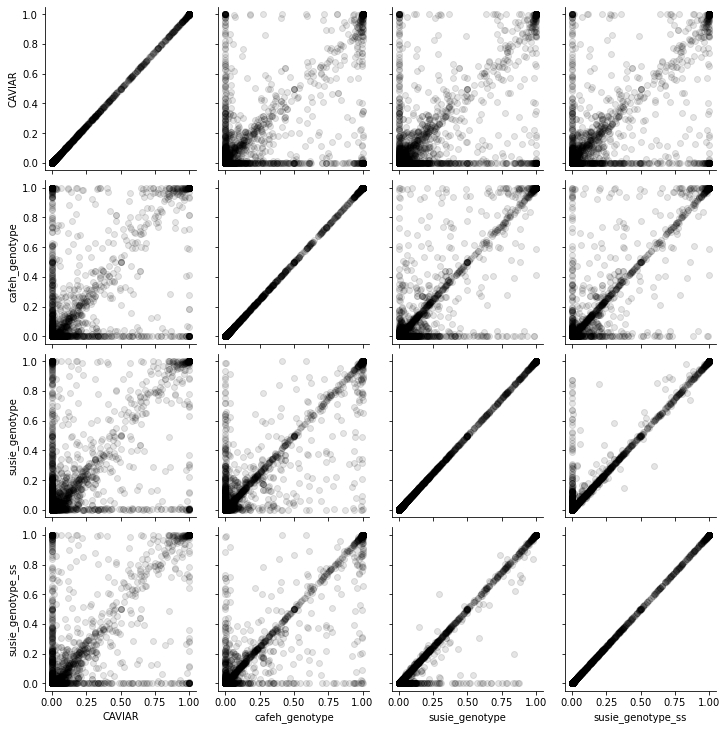

In [43]:
g = sns.PairGrid(pivot)
g = g.map(plt.scatter, color='k', alpha=0.1)

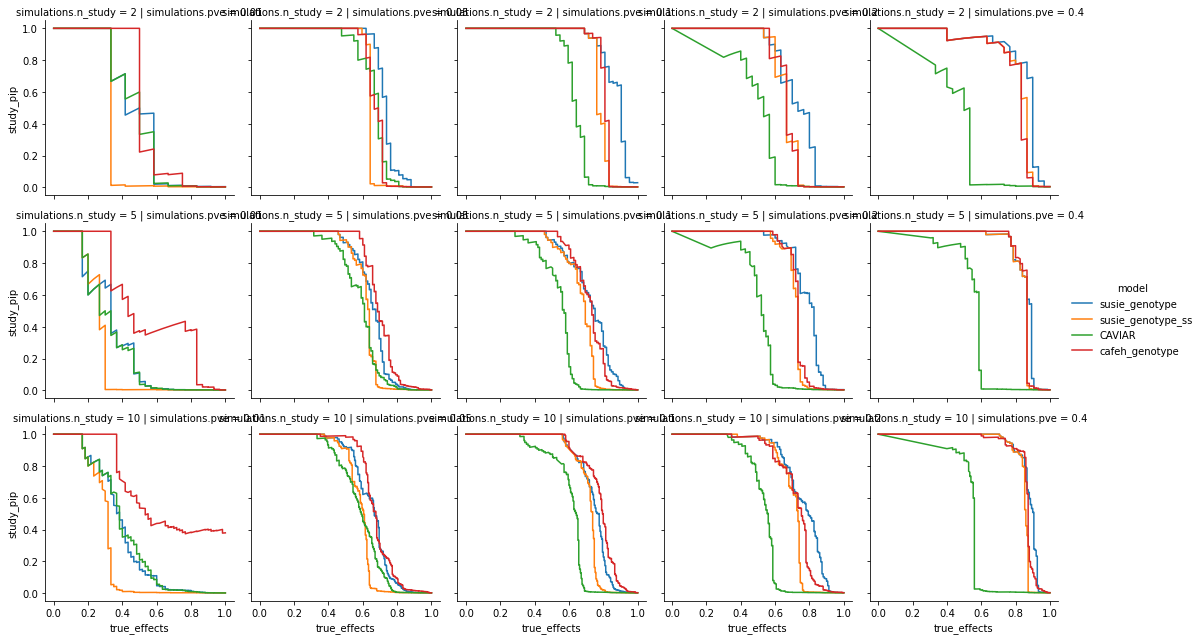

In [27]:
import seaborn as sns
models = ['susie_genotype', 'susie_genotype_ss', 'cafeh_genotype', 'CAVIAR']
df = query[query.model.isin(models)]
g = sns.FacetGrid(df, hue='model', col='simulations.pve', row='simulations.n_study')
g.map(_plot_pr, 'true_effects', 'study_pip')
g.add_legend();

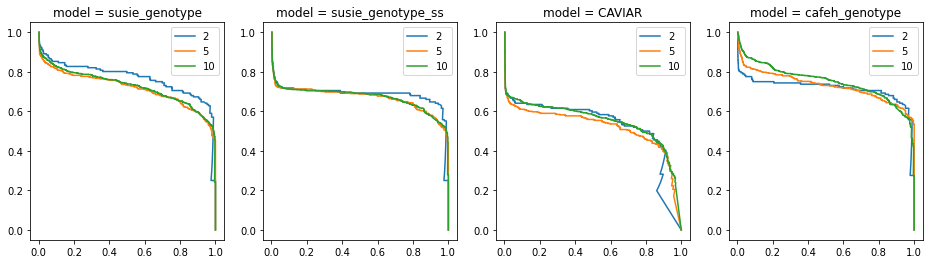

In [130]:
plot_pr_facet(query[query.model.isin(models)], 'model', 'simulations.n_study')

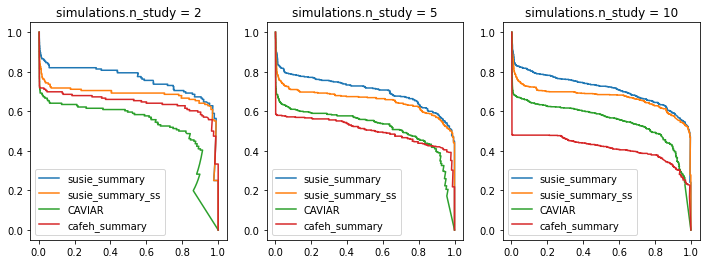

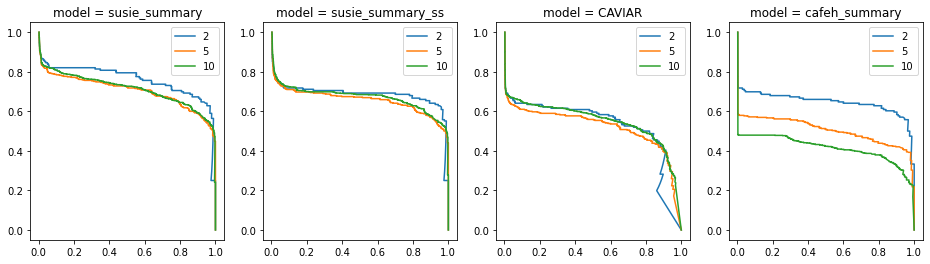

In [131]:
models = ['susie_summary', 'susie_summary_ss', 'cafeh_summary', 'CAVIAR']

plot_pr_facet(query[query.model.isin(models)], 'simulations.n_study', 'model')
plt.show()

plot_pr_facet(query[query.model.isin(models)], 'model', 'simulations.n_study')
plt.show()

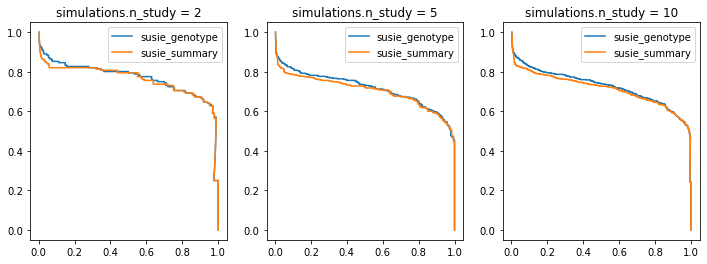

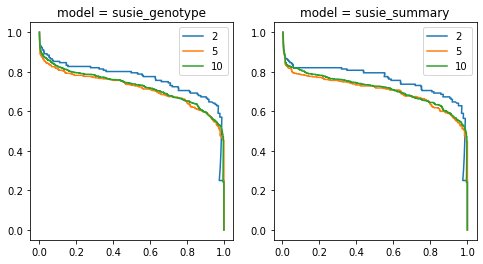

In [133]:
models = ['susie_summary', 'susie_genotype']

plot_pr_facet(query[query.model.isin(models)], 'simulations.n_study', 'model')
plt.show()

plot_pr_facet(query[query.model.isin(models)], 'model', 'simulations.n_study')
plt.show()

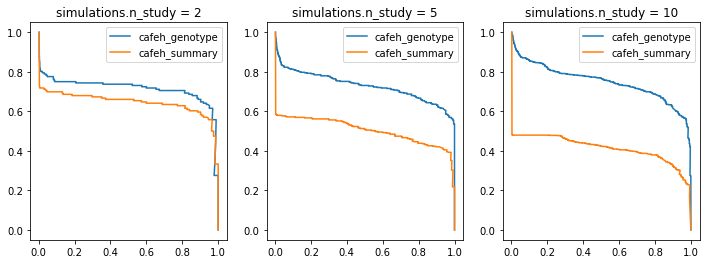

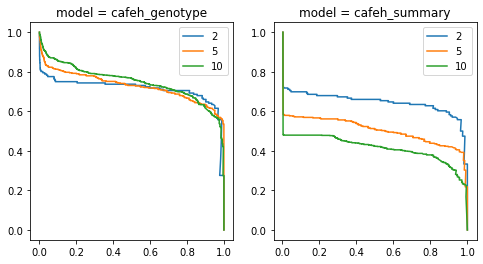

In [134]:
models = ['cafeh_summary', 'cafeh_genotype']

plot_pr_facet(query[query.model.isin(models)], 'simulations.n_study', 'model')
plt.show()

plot_pr_facet(query[query.model.isin(models)], 'model', 'simulations.n_study')
plt.show()

In [ ]:
plot_pr_factet(query[query.model.isin(models)], 'simulations.n_study', 'model')

In [ ]:
n_study = query.loc[:, 'simulations.n_study'].unique()
models = ['susie_genotype', 'susie_genotype_ss', 'cafeh_genotype', 'CAVIAR']


fig, ax = plt.subplots(1, n_study.size, figsize=(20, 5))
for i, n in enumerate(n_study):
    df = query[query.loc[:, 'simulations.n_study'] == n]

    
    plt.sca(ax[i])
    for model in models:
        make_pr_curve(df[df.model == model], model)
    plt.title('n_study = {}'.format(n))
    plt.legend()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


susie_genotype
susie_genotype_ss
cafeh_genotype
CAVIAR
susie_genotype
susie_genotype_ss
cafeh_genotype
CAVIAR
susie_genotype
susie_genotype_ss
cafeh_genotype
CAVIAR


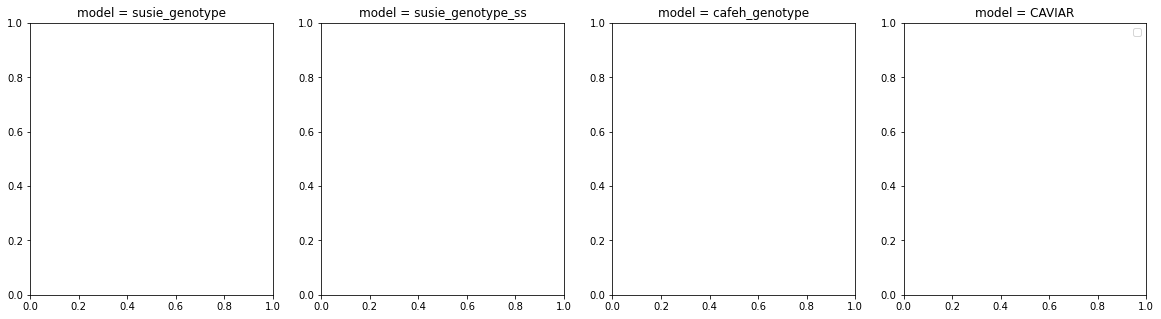

In [74]:
n_study = query.loc[:, 'simulations.n_study'].unique()

fig, ax = plt.subplots(1, len(models), figsize=(20, 5))
for n in enumerate(n_study):
    df = query[query.loc[:, 'simulations.n_study'] == n]
    models = ['susie_genotype', 'susie_genotype_ss', 'cafeh_genotype', 'CAVIAR']
    for i, model in enumerate(models):
        print(model)
        plt.sca(ax[i])
        try:
            make_pr_curve(df[df.model == model], model)
        except Exception:
            pass
        plt.title('model = {}'.format(model))
    plt.legend()

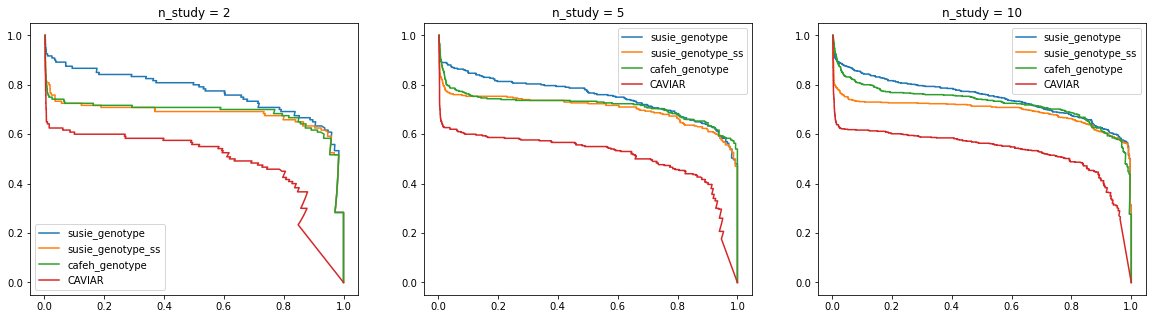

In [60]:
n_study = query.loc[:, 'simulations.n_study'].unique()

fig, ax = plt.subplots(1, n_study.size, figsize=(20, 5))
for i, n in enumerate(n_study):
    df = query[(query.loc[:, 'simulations.n_study'] == n) & (query.simulations == 'tissue_specific_sim')]

    models = ['susie_genotype', 'susie_genotype_ss', 'cafeh_genotype', 'CAVIAR']
    
    plt.sca(ax[i])
    for model in models:
        make_pr_curve(df[df.model == model], model)
        plt.title('n_study = {}'.format(n))
    plt.legend()

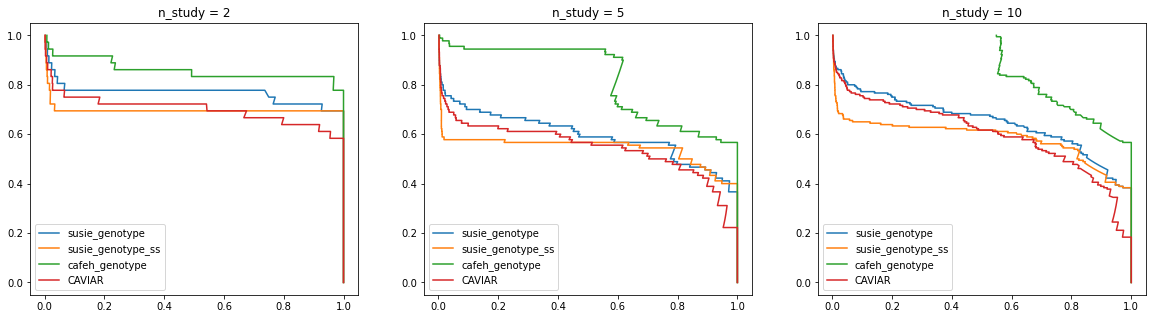

In [61]:
n_study = query.loc[:, 'simulations.n_study'].unique()

fig, ax = plt.subplots(1, n_study.size, figsize=(20, 5))
for i, n in enumerate(n_study):
    df = query[(query.loc[:, 'simulations.n_study'] == n) & (query.simulations == 'global_effect_sim')]

    models = ['susie_genotype', 'susie_genotype_ss', 'cafeh_genotype', 'CAVIAR']
    
    plt.sca(ax[i])
    for model in models:
        make_pr_curve(df[df.model == model], model)
        plt.title('n_study = {}'.format(n))
    plt.legend()

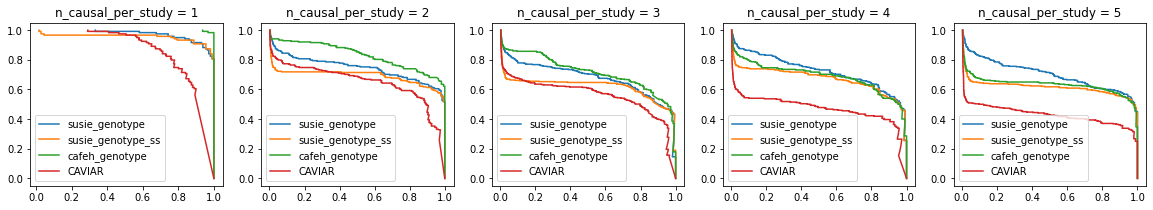

In [62]:
n_causal = query.loc[:, 'simulations.n_causal_per_study'].unique()

fig, ax = plt.subplots(1, n_causal.size, figsize=(20, 3))
for i, n in enumerate(n_causal):
    df = query[query.loc[:, 'simulations.n_causal_per_study'] == n]

    models = ['susie_genotype', 'susie_genotype_ss', 'cafeh_genotype', 'CAVIAR']
    
    plt.sca(ax[i])
    for model in models:
        make_pr_curve(df[df.model == model], model)
        plt.title('n_causal_per_study = {}'.format(n))
    plt.legend()

In [ ]:
n_causal = query.loc[:, 'simulations.n_causal_per_study'].unique()

fig, ax = plt.subplots(1, n_causal.size, figsize=(20, 3))
for i, n in enumerate(n_causal):
    df = query[query.loc[:, 'simulations.n_causal_per_study'] == n]

    models = ['susie_genotype', 'susie_genotype_ss', 'cafeh_genotype', 'CAVIAR']
    
    plt.sca(ax[i])
    for model in models:
        make_pr_curve(df[df.model == model], model)
        plt.title('n_causal_per_study = {}'.format(n))
    plt.legend()

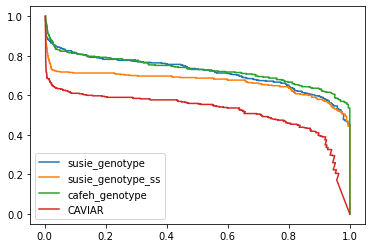

In [42]:
df = query[query.loc[:, 'simulations.n_study'] == 5]

models = ['susie_genotype', 'susie_genotype_ss', 'cafeh_genotype', 'CAVIAR']

for model in models:
    make_pr_curve(df[df.model == model], model)
plt.legend()

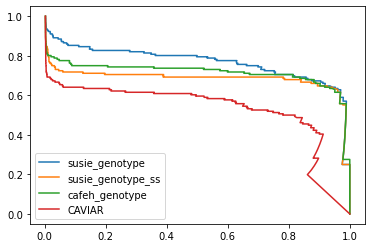

In [43]:
df = query[query.loc[:, 'simulations.n_study'] == 2]

models = ['susie_genotype', 'susie_genotype_ss', 'cafeh_genotype', 'CAVIAR']

for model in models:
    make_pr_curve(df[df.model == model], model)
plt.legend()

In [9]:
spec.groupby('model')

In [132]:
for oc in output_columns:
    target = oc.split('.')[1].split(':')[0]
    

Index(['fit_cafeh.study_pip:output', 'fit_susie.study_pip:output',
       'simulations.true_effects:output'],
      dtype='object')

In [ ]:
field = 

In [ ]:
spec.loc[i, 'stud_pip'] = study_pip

In [123]:
for i, row in spec.iterrows():
    print(i, row.model)
    study_pip = pickle.load(open('../prototype/{}.pkl'.format(row.path), 'rb'))['study_pip'].flatten()

    true_effects = pickle.load(open('../prototype/{}.pkl'.format(row.loc[
        'simulations.true_effects:output']), 'rb'))['true_effects'].flatten()

    spec.loc[i, 'stud_pip'] = tuple(study_pip)
    spec.loc[i, 'true_effects'] = tuple(true_effects.tolist())
    
    from prg import prg
    import numpy as np

    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.rcParams['figure.figsize'] = (6,5)

    prg_curve = prg.create_prg_curve(true_effects!=0, study_pip)
    prg.plot_prg(prg_curve)
    plt.show()

0 susie_genotype


ValueError: Must have equal len keys and value when setting with an iterable

In [124]:
tuple(study_pip)

(0.002519866139231164,
 0.002791002345303273,
 0.0024932785939875135,
 0.0024726167120954212,
 0.0027657266875871223,
 0.0023374591634515163,
 0.009410255549024193,
 0.002684770144154358,
 0.0031304411203356697,
 0.0034442280931133995,
 0.0041410334581446495,
 0.003030168678122669,
 0.0025017530910775854,
 0.002923385850244431,
 0.0030114637018494594,
 0.003260371772951798,
 0.0023690263342567297,
 0.006799134926410488,
 0.0026534918172358424,
 0.002776458563013673,
 0.0026665579847306997,
 0.00290726820489684,
 0.002483948281885806,
 0.00468420521950863,
 0.0024849998300393583,
 0.002832462453040363,
 0.0026855287845428677,
 0.0026900782242844645,
 0.003492085068013906,
 0.0027510775799844955,
 0.0033696424512172918,
 0.003462830637580794,
 0.004422336080948552,
 0.002273870503471276,
 0.0023703908619309155,
 0.005147309425451829,
 0.004169093139600788,
 0.0030331038519711973,
 0.005431785243823484,
 0.0039907133135083095,
 0.0032254717885453754,
 0.0024650829947190367,
 0.00371618092

In [112]:
pickle.load(open('../prototype/{}.pkl'.format(row.path), 'rb'))['study_pip']

array([[0.0017846 , 0.00296687, 0.01379428, ..., 0.00171966, 0.00940208,
        0.00193326],
       [0.0017846 , 0.00296687, 0.01379428, ..., 0.00171966, 0.00940208,
        0.00193326]])

In [107]:
true_effects.shape

(2000,)

In [103]:
pd.merge(spec.fit_cafeh.dropna(), spec.fit_susie.dropna(), left_index=True, right_index=True, how='outer')

,fit_cafeh,fit_susie
0,NaN,fit_susie_genotype
1,NaN,fit_susie_summary
2,NaN,fit_susie_genotype_ss
3,NaN,fit_susie_summary_ss
4,fit_cafeh_genotype,NaN
5,fit_cafeh_summary,NaN
6,fit_cafeh_summary_simple,NaN
7,NaN,fit_susie_genotype
8,NaN,fit_susie_summary
9,NaN,fit_susie_genotype_ss


In [4]:
import pickle

pickle.load(open('../prototype2/{}.pkl'.format(path), 'rb'))['study_pip']

FileNotFoundError: [Errno 2] No such file or directory: '../prototype2/fit_susie_genotype/small_genotype_1_one_study_sim_1_fit_susie_genotype_1.pkl'

In [13]:
import numpy as np
import time
np.random.seed(time.time())

TypeError: Cannot cast scalar from dtype('float64') to dtype('int64') according to the rule 'safe'

In [106]:
int((time.time() * 1e6) % (2**32 -1))

3058420237

In [35]:
np.random.seed(int((time.time() * 1e6) % (2**32 -1)))